<a href="https://colab.research.google.com/github/GreihMurray/KriolTranscriber/blob/master/basicnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import numpy as np
import itertools
from scipy.io import wavfile
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Reshape
from keras.models import load_model

In [ ]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
import pandas as pd
from tqdm import tqdm
import os
import unicodedata
import re

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
DEFAULT_DIR = '/content/gdrive/MyDrive/Colab_Notebooks/NLP/project/'
SR = 44100

In [ ]:
def load_html_data(dir_ext):
    all_data = []
    chars_to_replace = '.,;:<>?/\'\\[]()!#$%"”“'
    directory = DEFAULT_DIR + 'html/' + dir_ext + '/'

    dir_files = sorted(os.listdir(directory))

    for file in tqdm(dir_files, desc='Loading HTML Data'):
        file = directory + file
        divs = []
        with open(file, 'r', encoding='UTF-8') as in_file:
            data = ' '.join(in_file.readlines())
            data = unicodedata.normalize('NFC', data)
            data = re.sub(r'<span class=.*?</span>', '', data)
            data = re.sub(r'<a.*?</a>', '', data)
            data = data.replace(u'\xa0', u' ')
            check_divs = re.findall(r'<div class=\'mt\'.*?>(.*?) </div>', data)
            check_divs.extend(re.findall(r'<div class=\'mt2\'.*?>(.*?) </div>', data))
            # print(data)
            check_divs.extend(re.findall(r'<div class=\'ip\'>(.*)', data))

            if len(check_divs) > 0:
                full = '!'.join(check_divs)
                full = re.sub(r'[\,,@,#,$,%,^,&,*,(,),\[,\],\',\",;,:,“,”,‘,’]', '', full)
                full = re.sub('^\s+', ' ', full).strip('\u00A0')
                full = re.split('[\.,\?,!,\n]', str(full))
                all_data.extend([s.strip() for s in full])

            divs.extend(re.findall(r'<div class=\'[p,s]\'.*?>(.*?) </div>', data))

        full_data = '!'.join(divs)
        full_data = re.sub(r'[\,,@,#,$,%,^,&,*,(,),\[,\],\',\",;,:,“,”,‘,’]', '', full_data)
        full_data = re.sub(' +', ' ', full_data)
        full_data = re.split('[\.,\?,!,\n]', str(full_data))

        all_data.extend([s.strip() for s in full_data])

        clean = []
        for row2 in all_data:
            if len(row2) >= 1:
                clean.append(row2.lower())

    return clean

In [ ]:
def load_dataset(dir_ext):
    transcripts = load_html_data(dir_ext)
    all_x = []
    all_y = []
    directory = DEFAULT_DIR + 'audio/' + dir_ext + '/'

    order = []

    dir_files = sorted(os.listdir(directory))

    for i, file in tqdm(enumerate(dir_files), desc='Loading Audio Data & Creating Dataset'):
        file = directory + file
        
        sr, data = wavfile.read(file)

        max_len = SR//1000 * 15000

        if len(data) > max_len:
          continue

        all_x.append(data)
        all_y.append(transcripts[i].split(' '))


    return pd.DataFrame(list(zip(all_x, all_y)), columns=['audio', 'transcription'])

In [ ]:
def one_hot(data):
    mapping = {}
    mapped = []

    i = 0

    for sentence in data:
      cur_map = []
      for word in sentence:
          if word in mapping.keys():
            cur_map.append(mapping[word])
          else:
            i += 1
            cur_map.append(i)
            mapping[word] = i
            
      mapped.append(cur_map)
      
    return mapped, mapping

In [ ]:
def vectorize(data):
    vecs = []
    for row in data:
      cur_vec = [0] * len(row[0])
      for piece in row:
        piece = list(piece)
        cur_vec[piece.index(1)] += 1
      cur_vec[2] = 1
      vecs.append(cur_vec)

    return vecs

In [ ]:
def pad_audio(data):
    max_len = SR//1000 * 15000

    for i, aud in tqdm(enumerate(data), desc='Padding audio'):
      if len(aud) < max_len:
        data[i] = np.array(np.append(aud, np.zeros(max_len - len(aud))))

    return data

In [ ]:
def build_model(input_len, output_len):
    model = Sequential()
    model.add(Dense(256, input_shape=(input_len,), activation="sigmoid"))
    model.add(Dense(128, activation="sigmoid"))
    model.add(Dense(output_len, activation="relu"))

    model.compile(loss='poisson', metrics=['accuracy'])

    return model

In [ ]:
df = load_dataset('train')

Loading HTML Data: 100%|██████████| 293/293 [00:02<00:00, 139.69it/s]
Loading Audio Data & Creating Dataset: 0it [00:00, ?it/s]<ipython-input-31-c7e344a15f02>:14: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, data = wavfile.read(file)
Loading Audio Data & Creating Dataset: 356it [00:00, 387.87it/s]


In [ ]:
clean_y = list(df['transcription'])

In [ ]:
padded_y = list(zip(*itertools.zip_longest(*list(df['transcription']), fillvalue='<PAD>')))
enc_y, mapping = one_hot(padded_y)
enc_y = np.array(enc_y)
# cat_y = to_categorical(enc_y)
# vec_y = np.array(vectorize(cat_y))

In [ ]:
padded_x = pad_audio(df['audio'])

Padding audio: 306it [00:01, 191.28it/s]


In [ ]:
print(padded_x[0])

[-41. -35. -10. ...   0.   0.   0.]


In [ ]:
padded_x = np.stack(padded_x)

In [ ]:
model = build_model(len(padded_x[0]), len(enc_y[0]))

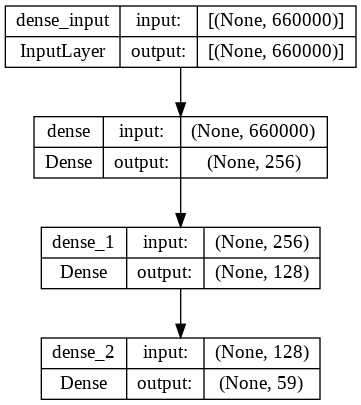

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
print(enc_y[1])

[3 4 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
print(padded_x.shape)
print(padded_x[0].shape)
print(enc_y.shape)

(306, 660000)
(660000,)
(306, 59)


In [ ]:
model = load_model('/content/gdrive/MyDrive/Colab_Notebooks/NLP/project/wordnet_model_200e')

In [ ]:
model.fit(padded_x, enc_y, epochs=100, verbose=1, batch_size=1)

Epoch 1/100
306/306 [==============================] - 267s 866ms/step - loss: 233.6441 - accuracy: 0.0458
Epoch 2/100
306/306 [==============================] - 267s 872ms/step - loss: 213.2359 - accuracy: 0.0588
Epoch 3/100
306/306 [==============================] - 261s 854ms/step - loss: 208.9512 - accuracy: 0.0588
Epoch 4/100
306/306 [==============================] - 262s 858ms/step - loss: 207.4192 - accuracy: 0.0588
Epoch 5/100
306/306 [==============================] - 261s 854ms/step - loss: 206.2954 - accuracy: 0.0588
Epoch 6/100
306/306 [==============================] - 262s 855ms/step - loss: 205.8677 - accuracy: 0.0588
Epoch 7/100
306/306 [==============================] - 262s 855ms/step - loss: 205.5182 - accuracy: 0.0588
Epoch 8/100
306/306 [==============================] - 263s 859ms/step - loss: 205.2205 - accuracy: 0.0588
Epoch 9/100
306/306 [==============================] - 262s 857ms/step - loss: 205.4807 - accuracy: 0.0588
Epoch 10/100
306/306 [===============

In [ ]:
model.save('/content/gdrive/MyDrive/Colab_Notebooks/NLP/project/wordnet_model_100e2')

In [ ]:
preds = model.predict(padded_x[:5])

1/1 [==============================] - 1s 598ms/step


In [ ]:
print(list(preds[0]))

[66.13661, 109.036766, 0.0, 0.0, 111.62733, 95.93621, 0.0, 94.761894, 0.0, 0.0, 69.42962, 0.0, 52.57881, 67.99912, 0.0, 0.0, 38.99269, 49.781887, 31.063395, 33.717102, 24.759535, 24.220665, 32.43302, 0.0, 13.708284, 21.450386, 0.0, 6.747005, 15.418666, 8.139862, 5.399017, 11.821401, 0.0, 7.876166, 3.942255, 0.0, 2.5254757, 2.4591565, 2.9225833, 2.4539628, 2.7839756, 0.0, 2.4897656, 0.0, 0.0, 0.0, 2.5664954, 2.3104184, 2.2063324, 2.0370448, 1.9999998, 2.172489, 2.0008678, 1.9680306, 2.0330603, 0.0, 0.0, 1.9677249, 0.0]


In [ ]:
model.evaluate(padded_x, enc_y, verbose=1)

10/10 [==============================] - 2s 174ms/step - loss: 165.5698 - accuracy: 0.0588


[165.56980895996094, 0.05882352963089943]

In [ ]:
print(mapping)

{'jenasis': 1, '<PAD>': 2, 'ola': 3, 'basdamwan': 4, 'stori': 5, 'wal': 6, 'dijan': 7, 'im': 8, 'stat': 9, 'garram': 10, 'det': 11, 'blanga': 12, 'god': 13, 'weya': 14, 'imbin': 15, 'meigim': 16, 'ebrijing': 17, 'en': 18, 'afta': 19, 'edam': 20, 'ib': 21, 'dubala': 22, 'bin': 23, 'orait': 24, 'longtaim': 25, 'wen': 26, 'meigimbat': 27, 'nomo': 28, 'enijing': 29, 'jidan': 30, 'jis': 31, 'eniwei': 32, 'oni': 33, 'strongbala': 34, 'woda': 35, 'goran': 36, 'ebriwei': 37, 'brabli': 38, 'dakbala': 39, 'spirit': 40, 'mubabat': 41, 'ontop': 42, 'langa': 43, 'brom': 44, 'deya': 45, 'tok': 46, 'lait': 47, 'streidawei': 48, 'kamat': 49, 'luk': 50, 'gudwan': 51, 'gudbinji': 52, 'kadimat': 53, 'gulum': 54, 'deitaim': 55, 'naitaim': 56, 'gowei': 57, 'ailibala': 58, 'sekan': 59, 'dei': 60, 'na': 61, 'larram': 62, 'samting': 63, 'miselpmiselp': 64, 'hepin': 65, 'lagijat': 66, 'dumaji': 67, 'ting': 68, 'bodam': 69, 'top': 70, 'skai': 71, 'hipimap': 72, 'miselp': 73, 'wan': 74, 'pleis': 75, 'draiwan': 7

In [ ]:
cur_words = []

preds = model.predict(padded_x)
all_words = []
map_list = mapping.items()

for pred in preds:
    for i, val in enumerate(pred):
        if val > 0.25:
          cur_words.append(''.join([item[0] for item in map_list if item[1] == i]))

    all_words.append(' '.join(cur_words))

10/10 [==============================] - 2s 166ms/step


In [ ]:
print(all_words[0])

 jenasis basdamwan stori dijan garram blanga god meigim ebrijing en afta edam ib dubala orait longtaim meigimbat nomo enijing jidan jis oni strongbala goran ebriwei brabli dakbala spirit ontop tok lait streidawei kamat luk gudwan gudbinji kadimat gulum gowei


In [ ]:
use_y = []

for row in clean_y:
    use_y.append(' '.join(row))

In [ ]:
!pip install evaluate
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached jiwer-2.5.1-py3-none-any.whl (15 kB)
  Using cached Levenshtein-0.20.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.4 MB)
     |████████████████████████████████| 2.2 MB 4.2 MB/s 


In [ ]:
from evaluate import load

In [ ]:
cer = load('cer')
cer_score = cer.compute(predictions=all_words, references=use_y)
print(cer_score)

445.6752792009141


In [ ]:
wer = load('wer')
wer_score = wer.compute(predictions=all_words, references=use_y)
print(wer_score)

358.06532368472523
